In [1]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from tests import data_loader
from tests.data_loader import *
from tests.data_loader import TestDataLoader

if torch.cuda.is_available():
    device = 'cuda'
else: 
    device = 'cpu'

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')
print(all_images[:10])

[
    » images\training\ADE_train_00000001.jpg,
    » images\training\ADE_train_00000002.jpg,
    » images\training\ADE_train_00000003.jpg,
    » images\training\ADE_train_00000004.jpg,
    » images\training\ADE_train_00000005.jpg,
    » images\training\ADE_train_00000006.jpg,
    » images\training\ADE_train_00000007.jpg,
    » images\training\ADE_train_00000008.jpg,
    » images\training\ADE_train_00000009.jpg,
    » images\training\ADE_train_00000010.jpg
]

In [3]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|███████████████████████████████████████████████████████████████████████████| 20210/20210 [02:04<00:00, 162.64it/s]


In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
        nzs = np.nonzero(r==_cls)
        instances = np.unique(g[nzs])
        for ix,_id in enumerate(instances):
            masks.append(g==_id)
            labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [6]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [7]:
get_mask(img_path)
    

[4, 6]

(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [8]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
        
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
            nzs = np.nonzero(r==_cls)
            instances = np.unique(g[nzs])
            for ix,_id in enumerate(instances):
                masks.append(g==_id)
                labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            box = np.array([xmin, ymin, xmax, ymax])

            boxes.append(list(np.clip(box, np.array([0,0,0,0]), np.array([img.size[0], img.size[1], img.size[0], img.size[1]]))))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img.float()/255., target
    
    def __len__(self):
        return self.N
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

x = MasksDataset(trn_items, get_transform(train=True), N=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


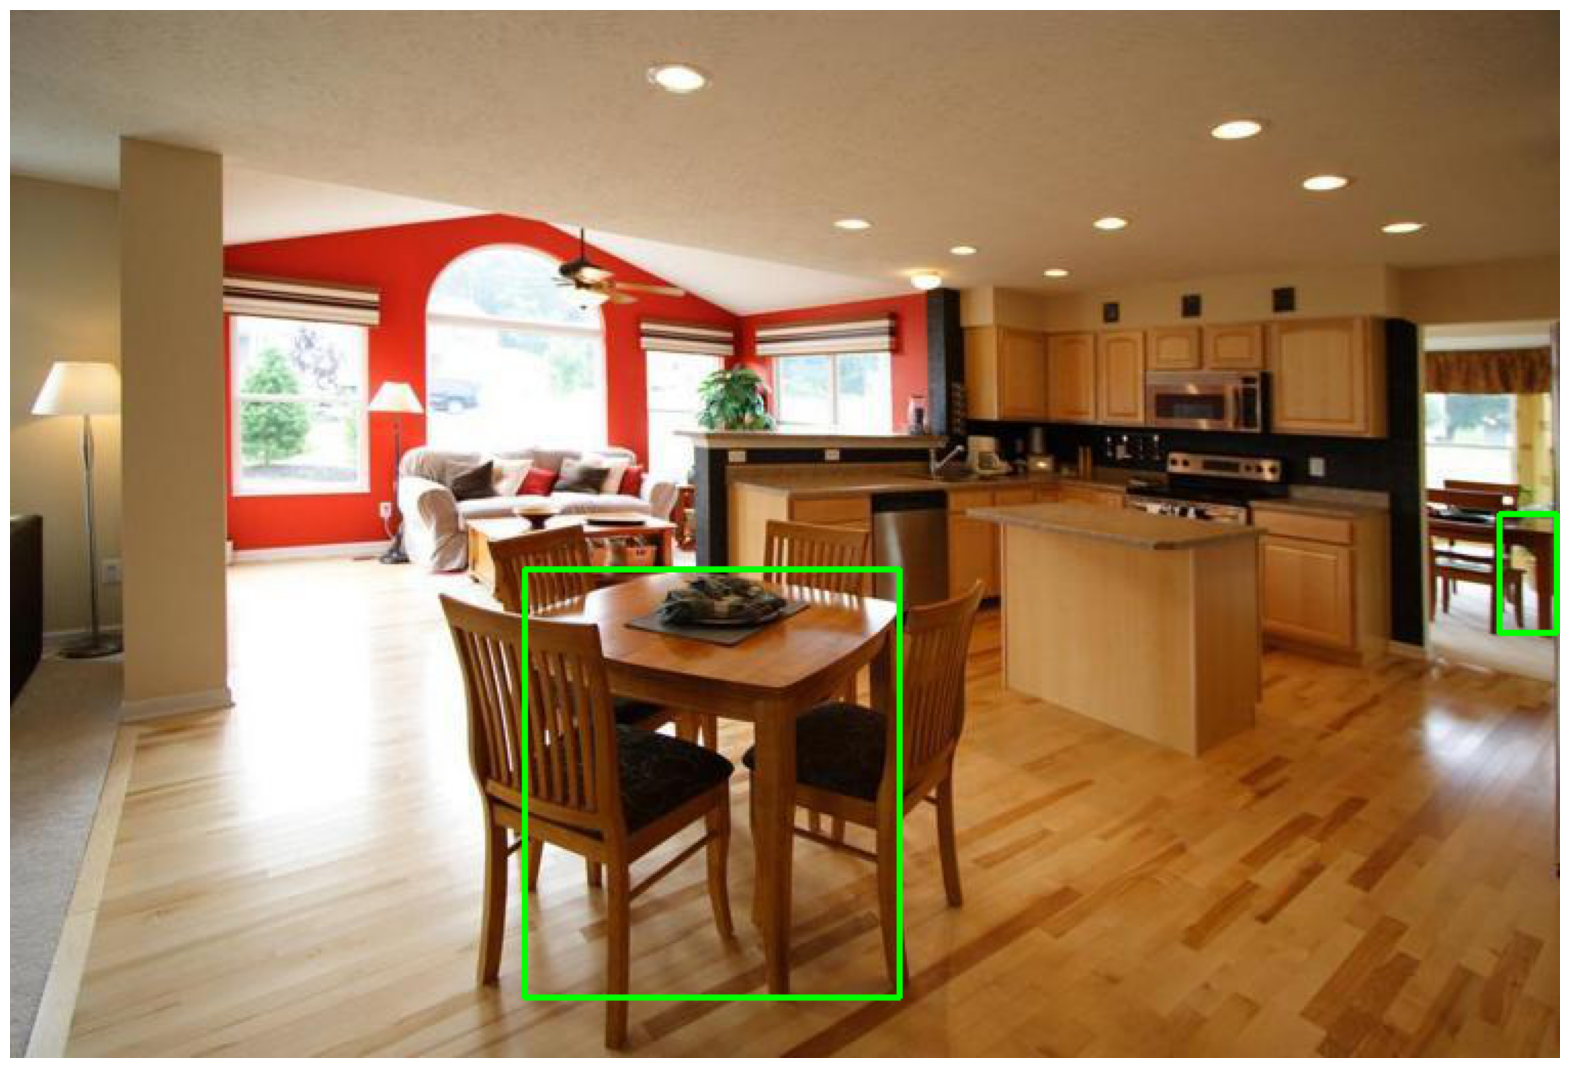

In [9]:
img, targ = x.__getitem__(5)
show(img.permute(1, 2, 0).numpy(), bbs=targ["boxes"])


In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [11]:
model = get_model_instance_segmentation(3).to(device)

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=dataset.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=dataset_test.collate_fn)

In [13]:
data_loader_tests = TestDataLoader(data_loader)
data_loader_tests.process_tests()

Test 1:  True
Test 2:  True
Test 3:  True
Test 4:  True
Test 5:  True
Test 6:  True
Test 7:  True
Test 8:  True


In [14]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [15]:
model.eval()
norm = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
norm(dataset[0][0][None].float())
pred = model(dataset[0][0][None].float().to(device))
inspect(pred[0])

══════════════════════════════════════════════════════════════════

dict of 4 items

BOXES:
        Tensor  Shape: torch.Size([100, 4])     Min: 38.553     Max: 411.784    Mean: 206.741   dtype: 
torch.float32 @ cuda:0

LABELS:
        Tensor  Shape: torch.Size([100])        Min: 1.000      Max: 2.000      Mean: 1.010     dtype: torch.int64 
@ cuda:0

SCORES:
        Tensor  Shape: torch.Size([100])        Min: 0.368      Max: 0.525      Mean: 0.422     dtype: 
torch.float32 @ cuda:0

MASKS:
        Tensor  Shape: torch.Size([100, 1, 310, 413])   Min: 0.000      Max: 1.000      Mean: 0.038     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

In [16]:
device

'cuda'

In [ ]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:07:50  lr: 0.000010  loss: 3.4599 (3.4599)  loss_classifier: 0.8040 (0.8040)  loss_box_reg: 0.4593 (0.4593)  loss_mask: 2.0753 (2.0753)  loss_objectness: 0.0395 (0.0395)  loss_rpn_box_reg: 0.0819 (0.0819)  time: 0.3138  data: 0.0100  max mem: 2886
Epoch: [0]  [  10/1500]  eta: 0:05:38  lr: 0.000060  loss: 3.0845 (3.1837)  loss_classifier: 0.8460 (0.8152)  loss_box_reg: 0.1862 (0.2856)  loss_mask: 2.0753 (2.0172)  loss_objectness: 0.0395 (0.0493)  loss_rpn_box_reg: 0.0082 (0.0163)  time: 0.2269  data: 0.0259  max mem: 3839
Epoch: [0]  [  20/1500]  eta: 0:05:38  lr: 0.000110  loss: 2.8470 (2.7571)  loss_classifier: 0.6636 (0.6840)  loss_box_reg: 0.1862 (0.2847)  loss_mask: 1.7952 (1.7204)  loss_objectness: 0.0297 (0.0511)  loss_rpn_box_reg: 0.0082 (0.0169)  time: 0.2245  data: 0.0278  max mem: 4147
Epoch: [0]  [  30/1500]  eta: 0:05:27  lr: 0.000160  loss: 1.8661 (2.4169)  loss_classifier: 0.4092 (0.5620)  loss_box_reg: 0.2373 (0.2797)  loss_mask: 1.1196 (

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [ ]:

k=423

In [ ]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

# Inspect the Data Loader

In [ ]:

for imgs, targets in data_loader:
    break
    

In [ ]:
item = targets[1]["iscrowd"]

print(type(item), item.dtype, item.shape, item.max(), item.min())

In [ ]:
img = torch.randn(3,223,223)

In [ ]:
if img.dtype == torch.float32:
    print("hello")

In [ ]:
import torch

In [ ]:
torch.clamp(torch.tensor([2,4,5,6,7]), max=5)

In [ ]:
import numpy as np

In [ ]:
np.clip(np.array([1,2,3,4,5]), np.array([2,2,2,2,2]), np.array([4,4,4,4,4]))

In [ ]:
box = np.array([24, 53, 128, 225])
img = torch.randn(3, 224, 224)
img.shape[0]